# Data Cleaning for Lead Exposure Project

In [1]:
# Packages to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rapidfuzz import process,fuzz
from sklearn.neighbors import BallTree

### Combine Service Line Inventory and Franklin County Parcel Data

In [2]:
# Import data files

# Documentation for the parcel data set is located at https://www.franklincountyauditor.com/AUDR-website/media/Documents/FTP/Parcel-CSV-description-of-fields.pdf
url_parcel = "https://apps.franklincountyauditor.com/Parcel_CSV/2025/05/Parcel.csv"
df_parcel = pd.read_csv(url_parcel)

# Service Line inventory data set
name_sl = "ServiceLineInventory.csv"
df_sl = pd.read_csv(name_sl)

/var/folders/2l/qpy8_v3d5x7glst5y2hhkz6m0000gn/T/ipykernel_5054/1256978046.py:5: DtypeWarning: Columns (12,13,14,15,31,33,54,59,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df_parcel = pd.read_csv(url_parcel)


In [3]:
# Create common Street Address column for both data sets
df_sl["Street Address"] = df_sl["Street Number"].astype(str) + ' ' + df_sl["Street Name"]

# Delete duplicate rows in each data set
df_parcel = df_parcel.drop_duplicates(subset=["STADDR"])
df_sl = df_sl.drop_duplicates(subset=["Street Address"])

In [4]:
# Find matching addresses in both data sets

common_values = set(df_sl['Street Address']) & set(df_parcel['STADDR'])
num_matches = len(common_values)
num_sl = len(df_sl)
num_parcel = len(df_parcel)

percent_match = num_matches/num_sl*100
percent_nomatch = 100-percent_match

# Data frame with exact matches for addresses
df_match_exact = pd.merge(df_sl, df_parcel, left_on="Street Address", right_on="STADDR", how="inner")

In [5]:
# Pull out all rows from Service Line Inventory without exact address matches
df_non_matches = df_sl[~df_sl["Street Address"].isin(df_parcel["STADDR"])]

# Consider a small sample of these rows
df_non_matches_sample = df_non_matches.sample(n=50)

def get_best_match(addr, choices, scorer=fuzz.token_sort_ratio):
    '''
    Use fuzzy logic package to match addresses. 
    addr: target address
    choices: range of possible addresses to match
    scorer: scoring method for fuzzy logic algorithm
    returns Pandas series containing the matched address and corresponding score
    '''

    results = process.extract(addr, choices, scorer=scorer,limit=5, score_cutoff=80)

    # If there are no results, return None
    if not results:
        return pd.Series([None, None])
    

     # See if address numbers are identical for any of the potential matches
    address_no = addr.split()[0]
    
    for match, score, _ in results:
        match_no = match.split()[0]
        if match_no == address_no:
            return pd.Series([match, score])
    
    # If no house number matches, return None
    return pd.Series([None, None])

        
## Get matches for sample dataset
"""
# Consider a small sample of these rows
df_non_matches_sample = df_non_matches.sample(n=50)

df_non_matches_sample[["Best Match", "Match Score"]] = df_non_matches_sample["Street Address"].apply(lambda addr: get_best_match(addr, df_parcel['STADDR']))
df_match_near = pd.merge(df_non_matches_sample, df_parcel, left_on="Best Match", right_on="STADDR", how="inner")
df_match_near = df_match_near.dropna(subset=['Best Match'])
"""

## Get matches for entire dataset. Uncomment to run code
"""
df_non_matches[["Best Match", "Match Score"]] = df_non_matches["Street Address"].apply(lambda addr: get_best_match(addr, df_parcel['STADDR']))
df_match_near = pd.merge(df_non_matches,df_parcel, left_on="Best Match", right_on="STADDR", how="inner")
df_match_near = df_match_near.dropna(subset=['Best Match'])

df_match_near.to_csv('data_match_near.csv')
"""

'\ndf_non_matches[["Best Match", "Match Score"]] = df_non_matches["Street Address"].apply(lambda addr: get_best_match(addr, df_parcel[\'STADDR\']))\ndf_match_near = pd.merge(df_non_matches,df_parcel, left_on="Best Match", right_on="STADDR", how="inner")\ndf_match_near = df_match_near.dropna(subset=[\'Best Match\'])\n\ndf_match_near.to_csv(\'data_match_near.csv\')\n'

In [6]:
# Load near matches data
df_match_near = pd.read_csv('data_match_near.csv')

# Clean up the two dataframes so they can be combined
df_match_exact["Match Score"] = 100

columns_filtered = ['PARCEL ID', 'YEARBLT',
                    'Street Number', 'Street Name', 'City', 'Zip Code', 'County', 'Latitude', 'Longitude', 
                    'System-Owned Portion Service Line Material Classification ',
                    'If Non-Lead in Column R.. Was Material Ever Previously Lead?',
                    'Customer-Owned Portion Service Line Material Classification']

df_match_exact_filtered = df_match_exact[columns_filtered]
df_match_near_filtered = df_match_near[columns_filtered]

# Dataframe with data for matched addresses in parcel and service line inventory
df_match_combined_filtered = pd.concat([df_match_exact_filtered,df_match_near_filtered])


/var/folders/2l/qpy8_v3d5x7glst5y2hhkz6m0000gn/T/ipykernel_5054/4188277848.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_match_near = pd.read_csv('data_match_near.csv')


In [7]:
# Check for null entries
df_match_combined_filtered.isnull().sum()

PARCEL ID                                                           0
YEARBLT                                                         13046
Street Number                                                       0
Street Name                                                         0
City                                                                0
Zip Code                                                            0
County                                                              0
Latitude                                                            0
Longitude                                                           0
System-Owned Portion Service Line Material Classification           0
If Non-Lead in Column R.. Was Material Ever Previously Lead?        0
Customer-Owned Portion Service Line Material Classification         0
dtype: int64

In [8]:
# Drop rows with null entries
df_match_combined_cleaned = df_match_combined_filtered.dropna()
df_match_combined_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224499 entries, 0 to 37074
Data columns (total 12 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   PARCEL ID                                                     224499 non-null  object 
 1   YEARBLT                                                       224499 non-null  float64
 2   Street Number                                                 224499 non-null  object 
 3   Street Name                                                   224499 non-null  object 
 4   City                                                          224499 non-null  object 
 5   Zip Code                                                      224499 non-null  object 
 6   County                                                        224499 non-null  object 
 7   Latitude                                                      

In [9]:
# Summarize address matching 
common_values = set(df_sl['Street Address']) & set(df_parcel['STADDR'])
num_matches = len(common_values)
num_sl = len(df_sl)
num_parcel = len(df_parcel)

num_near_matches = len(df_match_near)

percent_match = num_matches/num_sl*100
percent_near_match = num_near_matches/num_sl*100
percent_nomatch = 100-percent_match - percent_near_match

num_rows_final = len(df_match_combined_cleaned)
percent_final = num_rows_final/num_sl*100

print(f"Number of unique properties in parcel registry: {num_parcel}")
print(f"Number of unique properties listed in service line inventory: {num_sl}")
print(f"Number of exactly matching addresses: {num_matches} ({percent_match:0.1f}%)")
print(f"Number of nearly matching addresses: {num_near_matches} ({percent_near_match:0.1f}%)")
print(f"Number of non-matching addresses: {num_sl-num_matches} ({percent_nomatch:0.1f}%) \n")

print(f"Total number of properties with matching addresses and non-null entries:")
print(f"{num_rows_final} ({percent_final:0.1f}%)")      



Number of unique properties in parcel registry: 424706
Number of unique properties listed in service line inventory: 283876
Number of exactly matching addresses: 200470 (70.6%)
Number of nearly matching addresses: 37075 (13.1%)
Number of non-matching addresses: 83406 (16.3%) 

Total number of properties with matching addresses and non-null entries:
224499 (79.1%)


In [10]:
# Summarize stats on lead vs non-lead customer service line material
lead_counts_customer = df_match_combined_cleaned["Customer-Owned Portion Service Line Material Classification"].eq('PB').sum()
gal_counts_customer = df_match_combined_cleaned["Customer-Owned Portion Service Line Material Classification"].eq('GAL').sum()
nonlead_counts_customer = df_match_combined_cleaned["Customer-Owned Portion Service Line Material Classification"].isin(['CU','OT','PL']).sum()
unknown_counts_customer = df_match_combined_cleaned["Customer-Owned Portion Service Line Material Classification"].eq('MU').sum()

print("Customer Service Line Summary")
print(f"Properties with lead pipes: {lead_counts_customer}")
print(f"Properties with galvanized pipes: {gal_counts_customer}")
print(f"Properties with non-lead pipes: {nonlead_counts_customer}")
print(f"Properties with galvanized pipes: {gal_counts_customer}")
print(f"Properties with unknown service line material: {unknown_counts_customer}")

# Note that since there are no properties listed as having lead pipes, we cannot create a model for the customer-owned service line material

Customer Service Line Summary
Properties with lead pipes: 0
Properties with galvanized pipes: 8630
Properties with non-lead pipes: 160264
Properties with galvanized pipes: 8630
Properties with unknown service line material: 55605


In [11]:
# Summarize stats on lead vs non-lead city service line material
lead_counts_city = df_match_combined_cleaned["System-Owned Portion Service Line Material Classification "].eq('PB').sum()
gal_counts_city = df_match_combined_cleaned["System-Owned Portion Service Line Material Classification "].eq('GAL').sum()
nonlead_counts_city = df_match_combined_cleaned["System-Owned Portion Service Line Material Classification "].isin(['CU','OT','PL']).sum()
unknown_counts_city = df_match_combined_cleaned["System-Owned Portion Service Line Material Classification "].eq('MU').sum()

p_lead = lead_counts_city/(lead_counts_city+nonlead_counts_city+gal_counts_city)

print("City Service Line Summary")
print(f"Properties with lead pipes: {lead_counts_city}")
print(f"Properties with galvanized pipes: {gal_counts_city}")
print(f"Properties with non-lead pipes: {nonlead_counts_city}")
print(f"Properties with galvanized pipes: {gal_counts_city}")
print(f"Properties with unknown service line material: {unknown_counts_city}")

City Service Line Summary
Properties with lead pipes: 17277
Properties with galvanized pipes: 3418
Properties with non-lead pipes: 180984
Properties with galvanized pipes: 3418
Properties with unknown service line material: 22820


### Remove all data not used for plotting or model building

In [12]:
# Clip all data before 1920. Years listed before this are not reliable, according to Franklin County Auditor's Website
df_match_combined_cleaned["YEARBLT"] = df_match_combined_cleaned["YEARBLT"].clip(lower=1920) 

# Remove all rows with unknown service line material. These should not contribute to the model
df_match_combined_cleaned = df_match_combined_cleaned[df_match_combined_cleaned["System-Owned Portion Service Line Material Classification "] != "MU"]

/var/folders/2l/qpy8_v3d5x7glst5y2hhkz6m0000gn/T/ipykernel_5054/2258283085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match_combined_cleaned["YEARBLT"] = df_match_combined_cleaned["YEARBLT"].clip(lower=1920)


In [13]:
# Remove columns that do not contribute to the model or spatial plotting
columns_filtered_2 = ['PARCEL ID', 'YEARBLT',
                        'Street Number', 'Street Name', 'City', 'Zip Code', 'County', 'Latitude', 'Longitude', 
                        'System-Owned Portion Service Line Material Classification ']

df_match_combined_cleaned = df_match_combined_cleaned[columns_filtered_2]

In [14]:
df_match_combined_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201679 entries, 0 to 37074
Data columns (total 10 columns):
 #   Column                                                      Non-Null Count   Dtype  
---  ------                                                      --------------   -----  
 0   PARCEL ID                                                   201679 non-null  object 
 1   YEARBLT                                                     201679 non-null  float64
 2   Street Number                                               201679 non-null  object 
 3   Street Name                                                 201679 non-null  object 
 4   City                                                        201679 non-null  object 
 5   Zip Code                                                    201679 non-null  object 
 6   County                                                      201679 non-null  object 
 7   Latitude                                                    201679 non-null  flo

In [15]:
df_match_combined_cleaned["System-Owned Portion Service Line Material Classification "].value_counts()

System-Owned Portion Service Line Material Classification 
CU     76031
PL     70652
OT     34301
PB     17277
GAL     3418
Name: count, dtype: int64

### Encode categorical data for binary classification

In [16]:
df_match_combined_cleaned["is_lead"] = (df_match_combined_cleaned["System-Owned Portion Service Line Material Classification "]=="PB").astype(int)

# Use +/- 1 for lead/non-lead values. Makes nearest-neighbor analysis clearer
df_match_combined_cleaned['is_lead_pm'] = df_match_combined_cleaned['is_lead'].replace(0,-1)

## Additional code for predicting galvanized pipe presence
#df_match_combined_cleaned["is_galv"] = (df_match_combined_cleaned["System-Owned Portion Service Line Material Classification "]=="GAL").astype(int)
#df_match_combined_cleaned["needs_replaced"] = df_match_combined_cleaned["is_lead"] + df_match_combined_cleaned["is_galv"]

#### Use k-nearest neighbors to encode nearest neighbor (nn) is_lead values and associated distances

In [17]:
# Convert degrees to radians
coords_rad = np.radians(df_match_combined_cleaned[['Latitude', 'Longitude']].values)

# Build BallTree with haversine metric
tree = BallTree(coords_rad, metric='haversine')

# Query for k=2 (skip the point itself)
dists, indices = tree.query(coords_rad, k=2)

# Multiply by Earth radius (in km)
earth_radius_km = 6371.0
nearest_dists_km = dists[:, 1] * earth_radius_km
nearest_indices = indices[:, 1]
nearest_is_lead = df_match_combined_cleaned.iloc[nearest_indices]['is_lead_pm'].values

# Add to DataFrame
df_match_combined_cleaned['nn_is_lead'] = nearest_is_lead
df_match_combined_cleaned['nn_distance_km'] = nearest_dists_km

# Create weighted nearest neighbor lead value
epsilon = 1e-3  # to avoid division by zero. Corresponds to 1 meter 
df_match_combined_cleaned['nn_is_lead_weighted'] = df_match_combined_cleaned['nn_is_lead'] / (df_match_combined_cleaned['nn_distance_km'] + epsilon)

In [18]:
# Generate stats on nearest neighbor distance
df_match_combined_cleaned['nn_distance_km'].describe()

count    201679.000000
mean          0.019213
std           0.014387
min           0.000042
25%           0.013535
50%           0.017300
75%           0.022167
max           1.541509
Name: nn_distance_km, dtype: float64

array([[<Axes: title={'center': 'nn_distance_km'}>]], dtype=object)

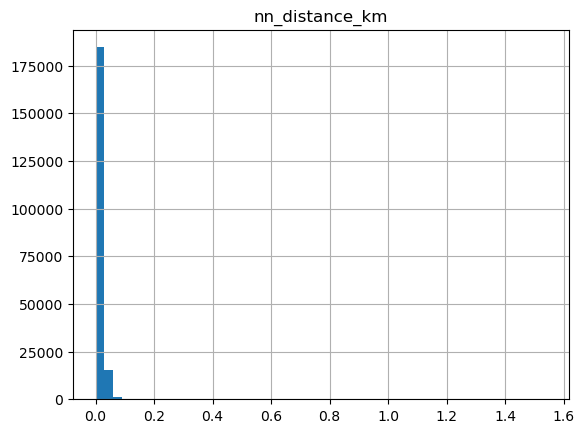

In [19]:
# take a look at the nearest neighbor distance data
df_match_combined_cleaned.hist(column='nn_distance_km', bins=51)

In [20]:
# Describe weighted nn lead values
df_match_combined_cleaned['nn_is_lead_weighted'].describe()

count    201679.000000
mean        -49.914263
std          65.812601
min        -959.424300
25%         -64.282831
50%         -51.696079
75%         -38.603676
max         351.127965
Name: nn_is_lead_weighted, dtype: float64

In [21]:
# Describe absolute value of nn lead values
abs(df_match_combined_cleaned['nn_is_lead_weighted']).describe()

count    201679.000000
mean         63.434596
std          52.903464
min           0.648294
25%          43.164339
50%          54.645790
75%          68.801187
max         959.424300
Name: nn_is_lead_weighted, dtype: float64

array([[<Axes: title={'center': 'nn_is_lead_weighted'}>]], dtype=object)

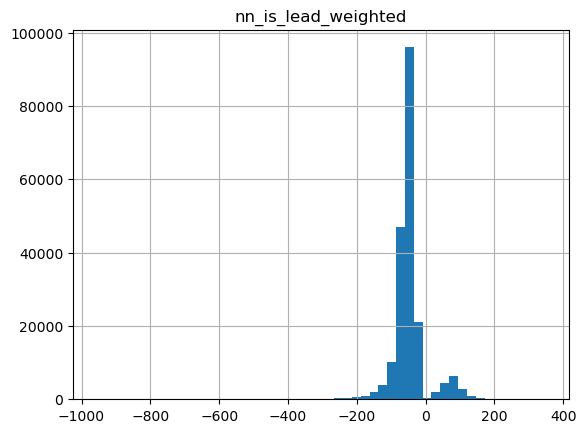

In [22]:
df_match_combined_cleaned.hist(column='nn_is_lead_weighted', bins=51)

In [23]:
# Save cleaned dataframe as csv.
df_match_combined_cleaned.to_csv('df_cleaned.csv')